#### Importing Libraries

In [2]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import time
from sortedcontainers import SortedSet # Used for fringe in A star
import queue # Used for fringe in BFS

#### Grid and Cell class

In [2]:
# Class cell -> its the class of all the nodes in the grid, Each cell of the grid is defined as a object of type 
# cell.
class cell:
    def __init__(self,x,y): # Constructor for class cell
        self.x = x # x coordinate of the cell
        self.y = y # y coordinate of the cell
        self.blocked = False # Flag to indicate whether the cell is blocked or not
        self.g = 0 # g value of the cell (the distance from start cell to curr cell)
        self.h = 0 # h value of the cell (estimated value of the distance between curr cell and goal cell)
        self.f = 0 # f value of the cell (f = g+h in A*, defines the priority of a node)
    def set_h_value(self, g_x, g_y, heuristic, weight):
        '''This function is used to assign the heuristic value i.e. the h value and the f value to the calling 
           class object. It takes in the argument g_x = goal cell abscissa, g_y = goal cell ordinate, 
           heuristic = It defines the type of heuristic the A* problem is using, weight = this is for problem 
           number 9 where we test the effect of weights on the performance of repeated A* and normal A*.'''
        if heuristic == 'm': 
            # Manhattan distance
            self.h = weight * abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.g + self.h # also updating f inside this function
        if heuristic == 'e':
            # euclidean distance
            self.h = weight * math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            self.f = self.g + self.h
        if heuristic == 'c':
            # chebyshev distance
            self.h = weight * max(abs(g_x - self.x), abs(g_y - self.y))
            self.f = self.g + self.h
        if heuristic == 'dec_weight_m':
            # dec_weight_m manhattan distance is used as the heuristic
            # Adaptive weight technique, nodes nearer to the goal cell are assigned lower weight and nodes farther
            # away from the goal cell are assigned greater weights.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            # if g < (2w-1)h then reduce the weight of g else reduce the weights of both g and h
            if self.g < (2*weight - 1) * self.h: 
                self.f = self.g / (2*weight - 1) + self.h 
            else:
                self.f = (self.g + self.h) / weight 
        if heuristic == 'dec_weight_e':
            # dec_weight_e euclidean distance is used as the heuristic
            self.h = math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            # same exp as in dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'dec_weight_c':
            # chebyshev distance is used as the heuristic
            self.h = max(abs(g_x - self.x), abs(g_y - self.y))
            # same explanation as dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'inc_weight_m':
            # This is also an adaptive weight technique, but instead of decreasing weight as we move along the 
            # path, we assign more weight to h.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            if self.g < self.h:
                self.f = self.g + self.h
            else:
                self.f = self.g + (2*weight-1)*self.h 
        if heuristic == 'g':
            # Toal greedy approach used in q4 to compare the speeds of A* and greedy best first search algorithm.
            # manhattan distance is used as heuristic
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.h

In [3]:
# Class grid_world -> This class is used to generate a grid world of dimension dim with each cell having 
# probability p of being blocked.
class grid_world:
    def __init__(self,p,dim):
        self.p = p # probability with which the cell is blocked
        self.dim = dim # dimension of the grid (dim x dim)
    def gen_grid(self,matrix):
        '''This function is used to generate the grid. The grid is returned in the form of list of list.'''
        for i in range(self.dim): # looping over the dimension to generate rows of cells
            a = [] # store a row of the grid of len dim
            for j in range(self.dim): # looping over the dim to generate cols of cells
                c = cell(i,j) # cell for coordinates (i,j)
                chance = random.uniform(0,1) 
                # generating a random number between 0 and 1 from uniform distribution, if its less than p 
                # the cell is blocked else the cell is unblocked.
                if i == 0 and j == 0: # [0,0] is the start cell location so don't want to block it, simply append
                    # and continue.
                    a.append(c)
                    continue
                if i == self.dim-1 and j == self.dim-1: #[dim-1, dim-1] is the goal cell location, so don't want to
                    # block it simply append and continue
                    a.append(c)
                    continue
                # if the number generated is less than or equal to p, block the cell.
                if(chance <= self.p):
                    c.blocked = True
                        
                a.append(c) # append the cell to the row
            matrix.append(a) # append the row to the grid
        return matrix # return the final grid

In [4]:
def gen_env(p, dim):
    '''Function to generate the enviornment with probability of blockage p and dimension = dim x dim'''
    temp = grid_world(p, dim)
    grid = temp.gen_grid([])
    return grid

In [5]:
def disp_grid(grid):
    '''Since our grid is a list of list of cells simply printing it does not work. This function prints the 
    grid with blockage as x and a cell on which we can travel as -'''
    l = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            if grid[i][j].blocked:
                a.append('x')
            else:
                a.append('-')
        l.append(a)
    return l

#### BFS and repeated BFS

In [6]:
def BFS(grid,start_cell_ind,goal_cell_ind):
    '''This function runs BFS on the grid. Returns the path and the number of cells processed.'''
    cells_processed = 0 # number of cells popped from the fringe before reaching the goal. 
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] # start cell of our grid.
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] # goal cell of our grid
    open_list = queue.Queue() # fringe, we have used a normal queue as the fringe as pop and push is O(1) and 
    # we don't need to update priorities as in BFS we go level by level.
    parent_dict = {} # stores parent child relationship
    visited = set() # Used to store if a node has already been visited or not
    open_list.put((start_cell.x, start_cell.y)) # pushing the start node to the fringe.
    visited.add((start_cell.x, start_cell.y)) # adding the start node to the visited set.
    while not open_list.empty(): # looping over the fringe until it becomes empty
        cl = open_list.get() # pop the left most element in the queue since lowest g value
        curr_cell = grid[cl[0]][cl[1]] # since we store the index in the queue we get the cell from real_world_grid
        cells_processed += 1 # cells_processed increased as we popped from the queue
        if curr_cell == goal_cell: 
            # If we reach the goal cell backtrack using the parent dictionary to the start cell and store all the 
            # nodes along this path in a list and return that list (This is the path we took in BFS).
            path = []
            curr = curr_cell
            while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
                path.append([curr.x, curr.y])
                curr = parent_dict[(curr.x, curr.y)]
            path.append([curr.x,curr.y])
            return path[::-1], cells_processed
        children = [] # Used to store all possible valid children of the current node.
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # We have assumed compass direction view for each cell in the grid.
            node_pos = (curr_cell.x+new_pos[0], curr_cell.y+new_pos[1]) # position of the children
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # If the position is not valid i.e. not inside the grid continue.
                continue
            if(grid[node_pos[0]][node_pos[1]].blocked):
                # If the child is blocked no need to consider it.
                continue
            if((node_pos[0], node_pos[1]) in visited):
                # In BFS if a node is already visited no need to consider it.
                continue
            # If a child Fails all the above conditions store it in the children list, it is a child who is not 
            # blocked, previously visited and is a part of the grid.
            children.append(grid[node_pos[0]][node_pos[1]])
        if(children == []): # If no valid children of a node continue.
            continue
        for child in children:
            open_list.put((child.x, child.y)) # add the child to the fringe
            parent_dict[(child.x, child.y)] = curr_cell # update the parent of the child
            visited.add((child.x, child.y)) # add the child to the visited list.
    return [], 0

In [7]:
def repeated_BFS(bot_env, real_world_grid, start_cell_ind, goal_cell_ind, final_discovered_grid_world, limited_view = False):
    '''This is the function to apply repeated BFS to an unkonwn envioenment. The bot_env passed in the function 
    is the current knowledge of the enviornement everything is assumed unblocked initially, real_world_grid is the actual enviornment and the 
    final_discovered gridworld is all of the enviornment which the agent has seen rest of all the 
    enviornment is blocked, initially everything in this grid is assumed to be blocked. limited_view parameter is used when the bot can only see in the direction it is 
    moving (Q7).'''
    paths = [] # Used to store all the path returned by repeated BFS.
    cp = 0 # Total number of cells processed by repeated BFS
    while(1): # Run while loop until termination
        # The termination conditions are : (1) if the goal state is reached (2) If the grid is not solveable
        path, cells_processed = BFS(bot_env, start_cell_ind, goal_cell_ind) #Run BFS on the bot_env containing all the knowledge the bot has acquired until now
        cp += cells_processed # add number of cells processed in BFS
        if(path == []): # If the path returned by BFS is empty the maze is not solveable.
            print("Maze is not solveable")
            break
        else: # If there is a path
            if not limited_view:
                # If we do not want the agent to have limited view call explore_path function, in this function 
                # we move on the path returned by BFS and update the knowledge of the enviornment 
                # in final_discovered_gridworld and bot_env
                # We return from explore_path the point till which we were able to explore the path returned by
                # BFS.
                p = explore_path(path,bot_env,real_world_grid, final_discovered_grid_world)
            else:
                # Call explore path with limited view since the agents field of view is limited. Works in the same
                # was as explore_path.
                p = explore_path_with_limited_view(path,bot_env,real_world_grid, final_discovered_grid_world)
            # append the path from start till the point till which we could travel in paths.
            paths.append(p)
            # If we reached the goal node without encountering the block return since the last index in p list 
            # will be goal cell in that case.
            if p[-1] == goal_cell_ind:
                return paths, cp
            # If we encountered a block and did not reach goal node re-run BFS with start node updated 
            # to the last unblocked cell along the path
            else:
                start_cell_ind = p[-1]

#### Astar

In [8]:
def Astar(grid,start_cell_ind,goal_cell_ind, heuristic, weight = 1):
    cells_processed = 0 # number of cells popped from the fringe before reaching the goal.
    number_of_clashes = 0 # number of time we had to update priorities in the fringe.
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] # start cell of our grid.
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] # goal cell of our grid
    open_list = SortedSet() # fringe, we have used sorted set as our priority queue
    close_list = set() # contains cells already processed, have used set for this purpose (O(1) lookup on average)
    parent_dict = {} # stores parent child relationship, using dictionary for this
    visited = set() # child already visited, using set for this purpose (O(1) lookup on average)
    start_cell.g = 0 # Setting the g value of the start cell to 0
    # setting the h and f value of the start cell using the weight and heuristic passed in the function arguments.
    # weight is for q9
    start_cell.set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
    open_list.add((start_cell.f, start_cell.h, (start_cell.x, start_cell.y))) # adding the start cell to the priority queue
    # In the queue we are pushing a tuple whose first coordinate is the f value, second coordinate is the h value 
    # then a tuple containing the location of the cell. The priority is set according to the f value in case of a 
    # tie h value is seen.
    visited.add((start_cell.x, start_cell.y)) # updating the visited set as we are pushing the node in priority queue
    while len(open_list)>0: # loop over the priority queue until it is not empty or we reach the goal node
        cl = open_list.pop(0) # pop the node with the least priority (it is at index 0 in the sorted set)
        curr_cell = grid[cl[-1][0]][cl[-1][1]] # the last index in cl contains the x and y coordinates, 
        # storing the node popped from the queue in curr_cell.
        cells_processed += 1 # incrementing the number of cells processed (since we just popped from the queue)
        close_list.add((curr_cell.x, curr_cell.y)) # adding the node to the closed list as it is about to be processed
        if curr_cell == goal_cell: 
            # If the curr cell is the goal cell return the path from the curr cell to goal cell by backtracking 
            # from goal cell to curr cell using the parent dictionary as well as all the nodes 
            # that have been processed uptil now.
            path = []
            curr = curr_cell
            while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
                path.append([curr.x, curr.y])
                curr = parent_dict[(curr.x, curr.y)]
            path.append([curr.x,curr.y])
            return path[::-1], cells_processed, number_of_clashes
        
        children = [] # This list is used to store all the possible valid children of the cell 
        # currently being processed.
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # 4 main compass directions, field of view also the agent can 
            # only move to these locations
            node_pos = (curr_cell.x+new_pos[0], curr_cell.y+new_pos[1]) # position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            if(grid[node_pos[0]][node_pos[1]].blocked):
                # if the child is blocked continue
                continue
            if((node_pos[0], node_pos[1]) in close_list):
                # if child is in close list continue
                continue
            if((node_pos[0], node_pos[1]) in visited):
                # if the child is already visited then compare the previous cost(f) to the new cost(f) and if the
                # new cost is lower update the priority of the child in the priority queue, update the 
                # parent dictionary and update the g value of the node.
                if curr_cell.g + 1 + grid[node_pos[0]][node_pos[1]].h < grid[node_pos[0]][node_pos[1]].f:
                    number_of_clashes += 1 # increment the number of clashes by 1
                    # To update the priority we remove the node from the sorted set (O(logn)) and reinsert with 
                    # new priority O(log(n)). 
                    open_list.remove((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    grid[node_pos[0]][node_pos[1]].g = curr_cell.g+1
                    grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                    open_list.add((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    parent_dict[(node_pos[0],node_pos[1])] = curr_cell # updating the parent dictionary
            else:
                # If the child is not visited update its g value, set its h and f value and add it to the 
                # children list after updating its parent.
                grid[node_pos[0]][node_pos[1]].g = curr_cell.g + 1
                grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                children.append(grid[node_pos[0]][node_pos[1]])
                parent_dict[(node_pos[0],node_pos[1])] = curr_cell
        if(children == []): # If no valid child continue
            continue
        for child in children: # else if valid children exist add them to the open list and update the visited set.
            open_list.add((child.f,child.h, (child.x, child.y)))
            visited.add((child.x, child.y))
    
    return [], 0, 0

#### Explore path function

In [9]:
# function to explore the path returned by A* algorithm. Update the bot_env and final_discovered_grid_world 
def explore_path(path,bot_env ,grid, final_discovered_grid_world):
    '''This functions helps move the agent along the path returned by A*. We update the bot enviornment and final 
    discovered grid world as the agent moves along the path. This function returns when the agent encounters a block 
    along the path or reaches the goal.'''
    # path is a list of list -> [[0,0], [0,2]......]
    for i in range(len(path)): # looping over the path list
        x = path[i][0] # x coordinate of the cell in the path 
        y = path[i][1] # y coordinate of the cell in the path
        # updating the information in the bot_env of the curr_cell
        bot_env[x][y].x = grid[x][y].x
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        # updating the information in the final discovered grid world of the curr_cell
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(grid[x][y].blocked): # if we encounter the blocked cell return the path till the last unblocked cell
            return path[:i]
        #this function is assumed that the agent has 4 main directions of a compass as field of view
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # In this loop we are updating the information in the bot_env
            # and final_discovered_gridworld for all the valid children of curr cell.
            node_pos = (x+new_pos[0], y+new_pos[1])#position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            # update information for the child in bot_env and final discovered grid world.
            bot_env[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            bot_env[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            bot_env[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
            final_discovered_grid_world[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            final_discovered_grid_world[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
    return path

In [10]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view(path,bot_env ,grid, final_discovered_grid_world):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    for i in range(len(path)): #looping over path list
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            return path[:i]
    
    return path

In [11]:
# function to explore path with improvement 
def explore_path_with_imp(path,bot_env ,grid, final_discovered_grid_world):
    '''
    This function is the solution to question 8 of the assignment which asks to improve the explore path algorithm 
    by finding a better position to restart the A* algorithm along the path the agent came from.    
    '''
    last_ind_with_option = [0,0] # stores the last index which had other possibilities to explore
    for i in range(len(path)): # loop over all the coordinates in path
        
        x = path[i][0]  #x coordinate of the first node
        y = path[i][1]  # y coordinate of the first node 
        # update the bot environment and final discovered grid world
        bot_env[x][y].x = grid[x][y].x  
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        
        # if blocked cell is encountered, return the path traversed till now along with the location of last possible 
        # cell to restart A* from.
        if(grid[x][y].blocked):
            return path[:i], last_ind_with_option

        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]:   # explore the children of the current node

            node_pos = (x+new_pos[0], y+new_pos[1])
            # if the child node is not valid, continue.
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                continue
            #update the bot environment and final discovered grid world
            bot_env[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            bot_env[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            bot_env[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
            final_discovered_grid_world[node_pos[0]][node_pos[1]].x = grid[node_pos[0]][node_pos[1]].x
            final_discovered_grid_world[node_pos[0]][node_pos[1]].y = grid[node_pos[0]][node_pos[1]].y
            final_discovered_grid_world[node_pos[0]][node_pos[1]].blocked = grid[node_pos[0]][node_pos[1]].blocked
            
            if i-1 > 0: #if the current child is the node which we came from, continue.
                if (node_pos[0] == path[i-1][0] and node_pos[1] == path[i-1][1]):
                    continue
            if i+1 < len(path): #if the current child is the next node in the path, continue.
                if (node_pos[1] == path[i+1][0] and node_pos[1] == path[i+1][1]):
                    continue
            
            if(grid[node_pos[0]][node_pos[1]].blocked): #if the child is a blocked node, continue.
                continue
            
            last_ind_with_option = [x,y] # Update the last index with option to the current node in the path. Since it has a child which is not explored by the path. Restarting A* from here we can explore that path.
        
        
    return path, 0  # return the path, index of last best option to restart A* from and location ((x,y) coordinate) of the best option  

#### Repeated A*

In [12]:
# function to implement the A* algorithm
def repeated_astar(bot_env, real_world_grid, start_cell_ind, goal_cell_ind, heuristic, final_discovered_grid_world, limited_view = False, weight=1, imp = False):
    '''
    This function is the implementation of the repeated A* algorithm. This function calls A* algorithm whenver a 
    blocked cell is encountered along the path returned by A*.
    '''
    
    paths = [] # stores the path to be returned.
    cp = 0  # keeps count of the total number of cells processed in each A* call.
    added_cost = 0  # cost of backtracking to the previous best node. Used for q8.
    #while the A* algorithm doesn't return a path or the maze is found to be not solvable 
    while(1):
        path, cells_processed, n_c = Astar(bot_env, start_cell_ind, goal_cell_ind, heuristic, weight) # call A* with current knowledge of the grid
        cp += cells_processed # add the number of cells processed to the variable cp which keeps the total number of cells processed for each iteration of A*
        if(path == []): # If A* doesn't return a path, path doesn't exist. Break from the loop and print "Maze is not solvable"
            print("Maze is not solveable")
            break
        else:  # If path exists, do this:
            if imp:   # if the parameter imp is set to true: Which means the optimized explore path function is used (for question 8).  
                # call explore path with improvement
                p, last_ind_with_option = explore_path_with_imp(path,bot_env,real_world_grid, final_discovered_grid_world)
            if not limited_view: # if the field of view is not limited
                p = explore_path(path,bot_env,real_world_grid, final_discovered_grid_world) #explore path with complete field of view
            else:
                p = explore_path_with_limited_view(path,bot_env,real_world_grid, final_discovered_grid_world) #explore path with limited view
            paths.append(p)  # append the path returned to paths  
            if p[-1] == goal_cell_ind: # if the last cell is goal cell, return paths, cells processed and added cost
                if imp:
                    return paths, cp, added_cost
                else:
                    return paths, cp
            else:    # if the last cell is not goal cell
                if imp:   # if the imp is set to true update start cell index to last_index_with_option.
                    start_cell_ind = last_ind_with_option
                    for i in range(len(p)):
                        if p[i] == last_ind_with_option:
                            added_cost += len(p)-1-i
                            break
                else:     # else update the start cell to the last cell of the path traversed till now
                    start_cell_ind = p[-1]

In [13]:
#function to print path
def print_path(paths):
    '''
    Function to print the path also we use it to get the final trajectory with backtracking taken by the agent. 
    '''
    l = [[0,0]] # start from [0,0]
    for path in paths: 
        l.extend(path[1:]) # extend the list with values of path 
    return l

### ------------------------------------------------------------------------------------------------------------------------------

#### Code for Q4

In [14]:
def is_solveable(grid, start_cell_ind, goal_cell_ind):
    '''This function tests the solvability of the grid passed in function argument by applying A* on that grid.
       If A* returns a path the maze is solvable else it is not solvable. 
    '''
    path, nodes_explored, n_c = Astar(grid, start_cell_ind, goal_cell_ind, 'm')
    if path == []:
        return False
    else:
        return True

In [15]:
def plot_density_solvebility():
    '''This function makes 1000 grids for p values from 0 to 1 with an increment of 0.01 and keeps count of 
    number of solvable grids amoung those 1000. This also plots the graph of density vs solvability. Ans to q4.'''
    p = 0 # density initially 0
    x = {} # dictionary that keeps count of number of grids solvable for each p value.
    while p <= 1: # iterating till value of p is less than or equal to 1
        x[p] = 0 # storing the count of solvable grids in x[p]
        for i in tqdm(range(1000)):
            real_world_grid = gen_env(p,101)
            if is_solveable(real_world_grid, [0,0], [100,100]): # check for solvability.
                x[p] += 1 # since the grid is solveable we update the count in x[p]
        p += 0.01
    lists = sorted(x.items())
    density, solvebility = zip(*lists) # making two lists from dictionary of density and solvebility
    solvebility = list(solvebility)
    density = list(density)
    for i in range(len(solvebility)):
        solvebility[i] = solvebility[i]/1000 # dividing the solvebility by 1000 to get a value between 0 to 1
    
    # Plotting the graph
    plt.plot(density, solvebility)
    plt.xticks(np.arange(0,1,0.1))
    plt.yticks(np.arange(0,1,0.1))
    plt.axvspan(0.3,0.3,color='red') # this marks the red lines in the graph after this most of the grids are not solveable.
    plt.axhspan(0.5,0.5,color='red')
    plt.xlabel('Density')
    plt.ylabel('Solvebility')
    return x

100%|██████████| 1000/1000 [00:11<00:00, 84.32it/s]


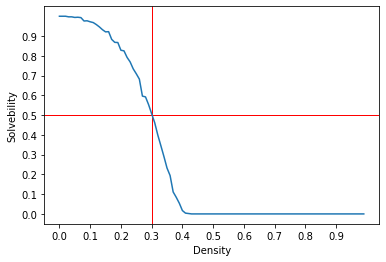

In [16]:
x = plot_density_solvebility()

Text(0, 0.5, 'Solvebility')

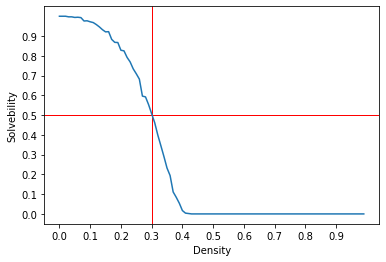

In [17]:
# Plotting the graph again.
lists = sorted(x.items())
density, solvebility = zip(*lists)
solvebility = list(solvebility)
density = list(density)
for i in range(len(solvebility)):
    solvebility[i] = solvebility[i]/1000

plt.plot(density, solvebility)
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
plt.axvspan(0.30,0.30,color='red')
plt.axhspan(0.5,0.5,color='red')
plt.xlabel('Density')
plt.ylabel('Solvebility')

In [35]:
# Here we are comparing the performance of A* algorithm and greedy best first search algorithm in terms of
# time on 50 grids.
count = 0
t1 = []
t2 = []
while(count < 50):
    real_world_grid = gen_env(0.2, 101)
    if(is_solveable(real_world_grid, [0,0], [100,100])):
        count += 1
        t = time.time()
        path,cp, nc = Astar(real_world_grid, [0,0], [100,100], 'm')
        t1.append(time.time()-t)
        
        t = time.time()
        path,cp, nc = Astar(real_world_grid, [0,0], [100,100], 'g')
        t2.append(time.time()-t)

Text(0, 0.5, 'time in sec')

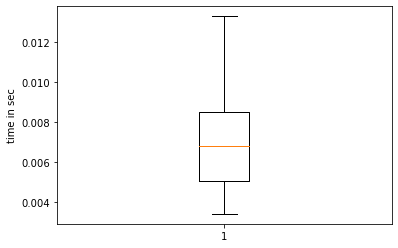

In [36]:
plt.boxplot(t1)
plt.ylabel('time in sec')

Text(0, 0.5, 'time in sec')

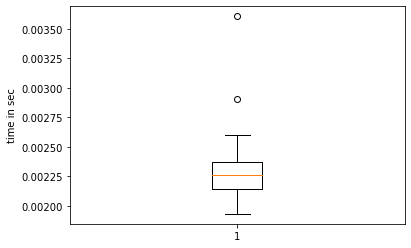

In [37]:
plt.boxplot(t2)
plt.ylabel('time in sec')

### ------------------------------------------------------------------------------------------------------------------------------

#### Code for Q5

In [18]:
"""To compare the heuristics we compare their performace on 1000 grids with p values 0.3 in terms of time, 
path_length and number of times we had to update the priority of nodes in the priority queue (number of clashes)."""
time_m = [] # list to store time it took for A* with manhattan heuristic to solve all grids
time_e = [] # list to store time it took for A* with eucledian heuristic to solve all grids
time_c = [] # list to store time it took for A* with chebyshev heuristic to solve all grids
len_path_m = [] # list to store path length of path returned by A* with manhattan heuristic
len_path_e = [] # list to store path length of path returned by A* with eucledian heuristic
len_path_c = [] # list to store path length of path returned by A* with chebyshev heuristic
c_m = [] # list to store number of clashes returned by A* with manhattan heuristic
c_e = [] # list to store number of clashes returned by A* with eucledian heuristic
c_c = [] # list to store number of clashes returned by A* with chebyshev heuristic
for i in tqdm(range(1000)):
    real_world_grid = gen_env(0.30, 101) # generating the grid with dim as 101 and density as 0.3
    if is_solveable(real_world_grid, [0,0], [100,100]):
        
        start = time.time() # stores the current time in start variable
        path_manhattan, nodes_exp_manhattan, n_c = Astar(real_world_grid, [0,0], [100,100], 'm') # running A* with manhattan heuristic on the grid
        end = time.time() # stores the time when loop reached here in end
        len_path_m.append(nodes_exp_manhattan) # appending the number of nodes explored by A*
        time_m.append(end-start) # total execution time of A* = end - start
        c_m.append(n_c) # appending number of collisions
        
        
        start = time.time() # stores the current time in start variable
        path_eucledian, nodes_exp_e, n_c = Astar(real_world_grid, [0,0], [100,100], 'e') # running A* with eucledian heuristic on the grid
        end = time.time() # stores the time when loop reached here in end
        len_path_e.append(nodes_exp_e) # appending the number of nodes explored by A*
        time_e.append(end-start)# total execution time of A* = end - start
        c_e.append(n_c)# appending number of collisions
        
        start = time.time() # stores the current time in start variable
        path_c, nodes_exp_c, n_c = Astar(real_world_grid, [0,0], [100,100], 'c') # running A* with chebyshev heuristic on the grid
        end = time.time() # stores the time when loop reached here in end
        time_c.append(end-start)# total execution time of A* = end - start
        len_path_c.append(nodes_exp_c)# appending the number of nodes explored by A*
        c_c.append(n_c)# appending number of collisions

100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]


#### Printing the outputs

In [19]:
sum(len_path_m)/len(len_path_m) # Average path length manhattan

1377.7029126213592

In [20]:
sum(len_path_e)/len(len_path_e) # Average path length eucledian

5619.615533980583

In [21]:
sum(len_path_c)/len(len_path_c) # Average path length Chebyshev

5727.168932038835

In [22]:
sum(time_m)/len(time_m) # Average time taken by manhattan to solve the grids

0.011096418714060367

In [23]:
sum(time_e)/ len(time_e) # Average time taken by eucledian to solve the grids

0.041397328052705934

In [24]:
sum(time_c)/ len(time_c) # Average time taken by chebyshev to solve the grids

0.03928642226654349

In [25]:
sum(c_m)/len(c_m) # number of collisions in manhattan

278.54368932038835

In [26]:
sum(c_e)/len(c_e) # number of collisions in eucledian

0.5786407766990291

In [27]:
sum(c_c)/len(c_c) # number of collisions in chebyshev

216.75339805825243

In [16]:
def disp_h_value(grid, goal_ind, heuristic):
    '''Function to plot the grid with all cells with heuristic value. Used to comparing diff heuristics.'''
    mat = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            grid[i][j].set_h_value(goal_ind[0], goal_ind[1], heuristic,1)
            a.append(round(grid[i][j].h, 2))
        mat.append(a)
    return mat

#### Displaying 10x10 grids with different heuristic values

In [39]:
disp_h_value(gen_env(0,10),[9,9], 'm')

[[18, 17, 16, 15, 14, 13, 12, 11, 10, 9],
 [17, 16, 15, 14, 13, 12, 11, 10, 9, 8],
 [16, 15, 14, 13, 12, 11, 10, 9, 8, 7],
 [15, 14, 13, 12, 11, 10, 9, 8, 7, 6],
 [14, 13, 12, 11, 10, 9, 8, 7, 6, 5],
 [13, 12, 11, 10, 9, 8, 7, 6, 5, 4],
 [12, 11, 10, 9, 8, 7, 6, 5, 4, 3],
 [11, 10, 9, 8, 7, 6, 5, 4, 3, 2],
 [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]

In [40]:
disp_h_value(gen_env(0,10),[9,9],'e')

[[12.73, 12.04, 11.4, 10.82, 10.3, 9.85, 9.49, 9.22, 9.06, 9.0],
 [12.04, 11.31, 10.63, 10.0, 9.43, 8.94, 8.54, 8.25, 8.06, 8.0],
 [11.4, 10.63, 9.9, 9.22, 8.6, 8.06, 7.62, 7.28, 7.07, 7.0],
 [10.82, 10.0, 9.22, 8.49, 7.81, 7.21, 6.71, 6.32, 6.08, 6.0],
 [10.3, 9.43, 8.6, 7.81, 7.07, 6.4, 5.83, 5.39, 5.1, 5.0],
 [9.85, 8.94, 8.06, 7.21, 6.4, 5.66, 5.0, 4.47, 4.12, 4.0],
 [9.49, 8.54, 7.62, 6.71, 5.83, 5.0, 4.24, 3.61, 3.16, 3.0],
 [9.22, 8.25, 7.28, 6.32, 5.39, 4.47, 3.61, 2.83, 2.24, 2.0],
 [9.06, 8.06, 7.07, 6.08, 5.1, 4.12, 3.16, 2.24, 1.41, 1.0],
 [9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0]]

In [41]:
disp_h_value(gen_env(0,10), [9,9], 'c')

[[9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 [9, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 [9, 8, 7, 7, 7, 7, 7, 7, 7, 7],
 [9, 8, 7, 6, 6, 6, 6, 6, 6, 6],
 [9, 8, 7, 6, 5, 5, 5, 5, 5, 5],
 [9, 8, 7, 6, 5, 4, 4, 4, 4, 4],
 [9, 8, 7, 6, 5, 4, 3, 3, 3, 3],
 [9, 8, 7, 6, 5, 4, 3, 2, 2, 2],
 [9, 8, 7, 6, 5, 4, 3, 2, 1, 1],
 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]

### ------------------------------------------------------------------------------------------------------------------------------

#### Code for Q6, Q7 and Extra Credit Problem of BFS

In [ ]:
p = 0 # initial value of p, we iterate p from 0 to 0.30 at the increment of 0.01

# The below four variables are for q6
avg_trajectory_length_q6 = [] # This variable stores the average trajectory length we got for 1000 solvable mazes for each value of p
avg_cell_processed_q6 = [] # This variable stores the average number of cells processed for 1000 solvable mazes for each value of p
average_trajectory_sp_dg_q6 = [] # This variable stores the average ratio of trajectory length by shortest path in discovered grid world we got for 1000 solvable mazes for each value of p
average_sp_dg_sp_cg_q6 = [] # This variable stores the average ratio of shortest path in discovered grid by shortest path in complete grid world world we got for 1000 solvable mazes for each value of p

# stores diff p values used for plotting
p_list = []

# the below four variables are for q7
avg_trajectory_length_q7 = []
avg_cell_processed_q7 = []
average_trajectory_sp_dg_q7 = []
average_sp_dg_sp_cg_q7 = []

# The below four variables are for q6 when we use repeated BFS
avg_trajectory_length_q6_bfs = []
avg_cell_processed_q6_bfs = []
average_trajectory_sp_dg_q6_bfs = []
average_sp_dg_sp_cg_q6_bfs = []

# The below four variables are for q7 when we use repeated BFS
avg_trajectory_length_q7_bfs = []
avg_cell_processed_q7_bfs = []
average_trajectory_sp_dg_q7_bfs = []
average_sp_dg_sp_cg_q7_bfs = []

pbar = tqdm(total = 31) # initializing a progress bar with max of 31 iterations
while(p <= 0.31): # while p is less than equal to 0.31 calculate the above matrics for each p and store them in their respective variables
    solve_count = 0 # we use this variable to maintain count of number of solvable matrices generated we terminate for each p when this count reaches 1000
    trajectory_length = 0 # used to store the trajectory length we got after solving the grid
    
    # below four variables are for q6
    tl_q6 = 0 # to store the sum of trajectory length we got for all 1000 grids
    cell_processed_q6 = 0 # to store the sum of number of processed cell we got for all 1000 grid
    tl_sp_dg_q6 = 0 # to store the sum of ratio of trajectory length with shortest path in discovered grid world we got for all 1000 grids
    sp_dg_sp_cg_q6 = 0 # to store the sum of ratio of shortest path in complete grid world with shortest path in discovered grid world we got for all 1000 grids
    
    # below four variables are for q7
    tl_q7 = 0
    cell_processed_q7 = 0
    tl_sp_dg_q7 = 0
    sp_dg_sp_cg_q7 = 0
    
    # below four variables store the sum when we apply repeated bfs on q6
    tl_q6_bfs = 0
    cell_processed_q6_bfs = 0
    tl_sp_dg_q6_bfs = 0
    sp_dg_sp_cg_q6_bfs = 0
    
    # below four variables store the sum when we apply repeated bfs on q7
    tl_q7_bfs = 0
    cell_processed_q7_bfs = 0
    tl_sp_dg_q7_bfs = 0
    sp_dg_sp_cg_q7_bfs = 0
    
    while(solve_count < 1000): # while the count of solvable grids are less than 1000 for each value of p go in the loop
        real_world_grid = gen_env(p,101) # generate a grid with dim 101 and density p
        if(is_solveable(real_world_grid, [0,0], [100,100])): # if the grid is solvable do the processing else continue till you get a solvable grid
            solve_count += 1 # increment the count of solvable grids
            
            bot_env = gen_env(0,101) # generate bot env to apply repeated A* on
            final_discovered_grid_world = gen_env(1,101) # generate the final_discovered_gridworld to be updated in repeated A*
            path,cp = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, False) # apply repeated A* with complete field of view on the grid
            trajectory_length = len(print_path(path)) # we use print path to get the final trajectory and store its length in the trajectory length variable for a single grid.
            tl_q6 += trajectory_length # sum of all trajectory lengths uptil now
            cell_processed_q6 += cp # summ of all cells processed uptil now
            tl_sp_dg_q6 += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0]) # sum of ratio uptil now, we find the shortest path by applying A* on the grid
            sp_dg_sp_cg_q6 += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0]) # sum of ratio uptil now
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            path,cp = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, True, 1) # Apply A* with limited field of view, we have set the limited_view flag as True
            trajectory_length = len(print_path(path))
            tl_q7 += trajectory_length
            cell_processed_q7 += cp
            tl_sp_dg_q7 += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q7 += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            path,cp = repeated_BFS(bot_env, real_world_grid, [0,0], [100,100], final_discovered_grid_world, False) # Here We apply Repeated BFS
            trajectory_length = len(print_path(path))
            tl_q6_bfs += trajectory_length
            cell_processed_q6_bfs += cp
            tl_sp_dg_q6_bfs += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q6_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            path,cp = repeated_BFS(bot_env, real_world_grid, [0,0], [100,100], final_discovered_grid_world, True) # Here we apply repeated BFS with limited_view flag as True so the agent will have limited field of view
            trajectory_length = len(print_path(path))
            tl_q7_bfs += trajectory_length
            cell_processed_q7_bfs += cp
            tl_sp_dg_q7_bfs += trajectory_length/len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm', weight=1)[0])
            sp_dg_sp_cg_q7_bfs += len(Astar(final_discovered_grid_world,[0,0],[100,100], 'm',weight=1)[0])/ len(Astar(real_world_grid,[0,0],[100,100], 'm', weight=1)[0])
            
        else:
            continue
    p_list.append(p)
    
    # taking the average of each sum and storing them in their respective variables
    avg_trajectory_length_q6.append(tl_q6/1000)
    avg_cell_processed_q6.append(cell_processed_q6/1000)
    average_trajectory_sp_dg_q6.append(tl_sp_dg_q6/1000)
    average_sp_dg_sp_cg_q6.append(sp_dg_sp_cg_q6/1000)
    
    
    avg_trajectory_length_q7.append(tl_q7/1000)
    avg_cell_processed_q7.append(cell_processed_q7/1000)
    average_trajectory_sp_dg_q7.append(tl_sp_dg_q7/1000)
    average_sp_dg_sp_cg_q7.append(sp_dg_sp_cg_q7/1000)
    
    avg_trajectory_length_q6_bfs.append(tl_q6_bfs/1000)
    avg_cell_processed_q6_bfs.append(cell_processed_q6_bfs/1000)
    average_trajectory_sp_dg_q6_bfs.append(tl_sp_dg_q6_bfs/1000)
    average_sp_dg_sp_cg_q6_bfs.append(sp_dg_sp_cg_q6_bfs/1000)
    
    avg_trajectory_length_q7_bfs.append(tl_q7_bfs/1000)
    avg_cell_processed_q7_bfs.append(cell_processed_q7_bfs/1000)
    average_trajectory_sp_dg_q7_bfs.append(tl_sp_dg_q7_bfs/1000)
    average_sp_dg_sp_cg_q7_bfs.append(sp_dg_sp_cg_q7_bfs/1000)
    
    p += 0.01 # update p value
    pbar.update(1) # update the progress bar
pbar.close()

#### Outputs

##### Trajectory length

In [ ]:
# Plot of average trajectory length for A* with 4 main compass direction as field of view
plt.plot(p_list, avg_trajectory_length_q6)
plt.xlabel('Density')
plt.ylabel('Average Trajectory Length')

In [ ]:
# Plot of average trajectory length for A* with limited field of view
plt.plot(p_list, avg_trajectory_length_q7)
plt.xlabel('Density')
plt.ylabel('Average Trajectory Length')

In [ ]:
plt.plot(p_list, (np.array(avg_trajectory_length_q6) - np.array(avg_trajectory_length_q7)))
plt.xlabel('Density')
plt.ylabel('Diff in length of trajectory')

In [ ]:
# Plot of average trajectory length for BFS with 4 main compass directions as field of view
plt.plot(p_list, avg_trajectory_length_q6_bfs)
plt.xlabel('Density')
plt.ylabel('Average Trajectory Length')

In [ ]:
# Plot of average trajectory length for BFS with limited field of view
plt.plot(p_list, avg_trajectory_length_q7_bfs)
plt.xlabel('Density')
plt.ylabel('Average Trajectory Length')

##### Cells processed

In [ ]:
# Plot of average cells processed for A* with 4 main compass direction as field of view
plt.plot(p_list, avg_cell_processed_q6)
plt.xlabel('Density')
plt.ylabel('Avg cells processed')

In [ ]:
# Plot of average cells processed for A* with limited field of view
plt.plot(p_list, avg_cell_processed_q7)
plt.xlabel('Density')
plt.ylabel('Avg cells processed')

In [ ]:
# Plot of average cells processed for BFS with 4 main compass direction as field of view
plt.plot(p_list, avg_cell_processed_q6_bfs)
plt.xlabel('Density')
plt.ylabel('Avg cells processed')

In [ ]:
# Plot of average cells processed for BFS with limited field of view
plt.plot(p_list, avg_cell_processed_q7_bfs)
plt.xlabel('Density')
plt.ylabel('Avg cells processed')

##### Trajectory length vs shortest path in discovered gridworld

In [ ]:
# Plot of average ratio of trajectory length by shortest path in discovered gridworld for A* with 4 main compass direction as field of view
plt.plot(p_list, average_trajectory_sp_dg_q6)
plt.xlabel('Density')
plt.ylabel('Trajectory/SP in DG')

In [ ]:
# Plot of average ratio of trajectory length by shortest path in discovered gridworld for A* with limited field of view
plt.plot(p_list, average_trajectory_sp_dg_q7)
plt.xlabel('Density')
plt.ylabel('Trajectory/SP in DG')

In [ ]:
# Plot of average ratio of trajectory length by shortest path in discovered gridworld for BFS with 4 main compass direction as field of view
plt.plot(p_list, average_trajectory_sp_dg_q6_bfs)
plt.xlabel('Density')
plt.ylabel('Trajectory/SP in DG')

In [ ]:
# Plot of average ratio of trajectory length by shortest path in discovered gridworld for BFS with limited field of view
plt.plot(p_list, average_trajectory_sp_dg_q7_bfs)
plt.xlabel('Density')
plt.ylabel('Trajectory/SP in DG')

##### SP in DG by SP in CG

In [ ]:
#Plot of average ratio of shortest path in discovered gridworld by shortest path in complete gridworld for A* with 4 main compass direction as field of view
plt.plot(p_list, average_sp_dg_sp_cg_q6)
plt.xlabel('Density')
plt.ylabel('SP(Discovered Gridworld)/SP(Complete Gridworld)')

In [ ]:
#Plot of average ratio of shortest path in discovered gridworld by shortest path in complete gridworld for A* with limited field of view
plt.plot(p_list, average_sp_dg_sp_cg_q7)
plt.xlabel('Density')
plt.ylabel('SP(Discovered Gridworld)/SP(Complete Gridworld)')

In [ ]:
#Plot of average ratio of shortest path in discovered gridworld by shortest path in complete gridworld for BFS with 4 main compass direction as field of view
plt.plot(p_list, average_sp_dg_sp_cg_q6_bfs)
plt.xlabel('Density')
plt.ylabel('SP(Discovered Gridworld)/SP(Complete Gridworld)')

In [ ]:
#Plot of average ratio of shortest path in discovered gridworld by shortest path in complete gridworld for A* with limited field of view
plt.plot(p_list, average_sp_dg_sp_cg_q7_bfs)
plt.xlabel('Density')
plt.ylabel('SP(Discovered Gridworld)/SP(Complete Gridworld)')

### ------------------------------------------------------------------------------------------------------------------------------

#### Q8 comparsion of repeated A* with improvement and without improvement

In [17]:
p = 0

avg_trajectory_length_q6 = []
avg_cell_processed_q6 = []
avg_time_q6 = []

p_list = []

avg_trajectory_length_q7 = []
avg_cell_processed_q7 = []
avg_time_q7 = []

pbar = tqdm(total = 7)
while(p <= 0.3):
    solve_count = 0
    trajectory_length = 0
    
    tl_q6 = 0
    cell_processed_q6 = 0
    time_q6 = 0
    
    tl_q7 = 0
    cell_processed_q7 = 0
    time_q7 = 0
    
    while(solve_count < 500):
        real_world_grid = gen_env(p,101)
        if(is_solveable(real_world_grid, [0,0], [100,100])):
            solve_count += 1
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp,added_cost = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, False, 1, imp=True)
            time_q6 += time.time()-t
            trajectory_length = len(print_path(path)) + added_cost
            cell_processed_q6 += cp
            tl_q6 += trajectory_length
            
            bot_env = gen_env(0,101)
            final_discovered_grid_world = gen_env(1,101)
            t = time.time()
            path,cp = repeated_astar(bot_env, real_world_grid, [0,0], [100,100], 'm', final_discovered_grid_world, True, 1, imp = False)
            time_q7 += time.time()-t
            trajectory_length = len(print_path(path))
            tl_q7 += trajectory_length
            cell_processed_q7 += cp
        else:
            continue
    p_list.append(p)
    
    avg_trajectory_length_q6.append(tl_q6/500)
    avg_cell_processed_q6.append(cell_processed_q6/500)
    avg_time_q6.append(time_q6/500)
    
    avg_trajectory_length_q7.append(tl_q7/500)
    avg_cell_processed_q7.append(cell_processed_q7/500)
    avg_time_q7.append(time_q7/500)
    
    p += 0.05
    pbar.update(1)
pbar.close()

100%|██████████| 7/7 [19:11<00:00, 164.44s/it]


In [18]:
avg_trajectory_length_q6

[201.0, 212.596, 228.408, 249.34, 280.876, 323.24, 391.652]

In [19]:
avg_trajectory_length_q7

[201.0, 212.596, 228.412, 249.388, 280.788, 322.812, 390.808]

Text(0, 0.5, 'avg_trajectory length')

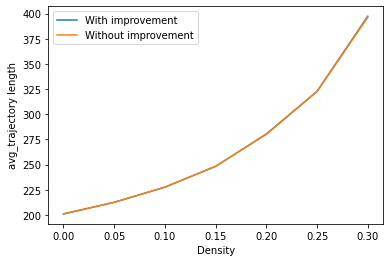

In [6]:
plt.plot(p, [201.0, 212.512, 227.58, 248.256, 280.388, 322.848, 397.38])
plt.plot(p,[201.0, 212.512, 227.588, 248.328, 280.04, 322.504, 396.42])
plt.legend(['With improvement', 'Without improvement'] )
plt.xlabel('Density')
plt.ylabel('avg_trajectory length')

In [20]:
avg_cell_processed_q6

[201.0, 1254.33, 2428.676, 3695.404, 5301.808, 7084.492, 10017.964]

In [21]:
avg_cell_processed_q7

[201.0, 1309.398, 2673.32, 4301.928, 6559.592, 9322.604, 14012.718]

Text(0, 0.5, 'avg_cells_processed')

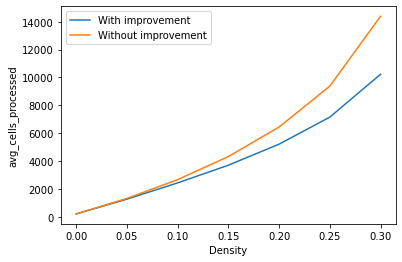

In [13]:
plt.plot(p, [201.0, 1261.28, 2429.266, 3699.522, 5212.422, 7154.396, 10231.152])
plt.plot(p,[201.0, 1315.292, 2665.608, 4319.628, 6444.69, 9382.078, 14399.098])
plt.legend(['With improvement', 'Without improvement'] )
plt.xlabel('Density')
plt.ylabel('avg_cells_processed')

In [22]:
avg_time_q6

[0.004196856021881103,
 0.014528759479522705,
 0.025578328132629394,
 0.037968716144561765,
 0.054639158248901365,
 0.07156748676300048,
 0.10031313753128052]

In [4]:
p = [0,0.05,0.1,0.15,0.2,0.25,0.3]

Text(0, 0.5, 'time in sec')

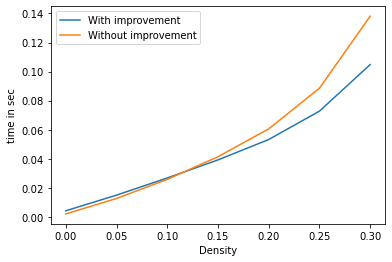

In [8]:
y1 = [0.004222334861755371,
0.014984403610229492,
 0.026795461654663087,
 0.03922902202606201,
 0.05325496768951416,
 0.07277054691314697,
 0.10480460119247437]
plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3],y1)

y2 = [0.002061413288116455,
 0.012694456100463868,
 0.025828443050384522,
 0.04139853668212891,
 0.06057038021087646,
 0.08854127216339111,
 0.1380766668319702]

plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3],y2)

plt.legend(['With improvement', 'Without improvement'] )
plt.xlabel('Density')
plt.ylabel('time in sec')

In [24]:
avg_time_q7

[0.002009624481201172,
 0.012344284534454346,
 0.02476350498199463,
 1.1375987749099732,
 0.06222193765640259,
 0.08739434766769409,
 0.13143075466156007]

### ------------------------------------------------------------------------------------------------------------------------------

#### Code for Q9

#### Effect of weight on A*

In [ ]:
p_time_dict_m = {}
p_path_dict_m = {}
p_np_dict_m = {}

p_time_dict_e = {}
p_path_dict_e = {}
p_np_dict_e = {}

p_time_dict_c = {}
p_path_dict_c = {}
p_np_dict_c = {}

weight = [0.5,1,1.5,2,3, 5, 7]

for p in tqdm([0.25]):
    print(p)
    time_m = []
    time_e = []
    time_c = []
    path_m = []
    path_e = []
    path_c = []
    np_m = []
    np_e = []
    np_c = []
    count = 0
    while(count < 500):
        if(count % 50 == 0):
            print(count)
        real_world_grid = gen_env(p, 101)
        if (not is_solveable(real_world_grid, [0,0], [100,100])):
            continue
        else:
            count += 1
            timer_m = []
            cp_m = []
            p_m = []
            
            timer_e = []
            cp_e = []
            p_e = []

            timer_c = []
            cp_c = []
            p_c = []
            for w in weight:
                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp,nc = Astar(real_world_grid,[0,0], [100,100], 'm', w)
                timer_m.append(time.time()-t)
                cp_m.append(cp)
                p_m.append(len(print_path(path)))


                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp,nc = Astar(real_world_grid,[0,0], [100,100], 'e', w)
                timer_e.append(time.time()-t)
                cp_e.append(cp)
                p_e.append(len(print_path(path)))

                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp,nc = Astar(real_world_grid,[0,0], [100,100], 'c', w)
                timer_c.append(time.time()-t)
                cp_c.append(cp)
                p_c.append(len(print_path(path)))

        time_m.append(timer_m)
        np_m.append(cp_m)
        path_m.append(p_m)

        time_e.append(timer_e)
        np_e.append(cp_e)
        path_e.append(p_e)

        time_c.append(timer_c)
        np_c.append(cp_c)
        path_c.append(p_c)
        
    p_time_dict_m[p] = time_m
    p_path_dict_m[p] = path_m
    p_np_dict_m[p] = np_m
        
    p_time_dict_e[p] = time_e
    p_path_dict_e[p] = path_e
    p_np_dict_e[p] = np_e
        
    p_time_dict_c[p] = time_c
    p_path_dict_c[p] = path_c
    p_np_dict_c[p] = np_c

#### Time

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_m[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_m[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_m[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_m[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_m[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_m[0.25]]
w_5_p_0_time_m = [i[6] for i in p_time_dict_m[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_e[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_e[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_e[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_e[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_e[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_e[0.25]]
w_5_p_0_time_m = [i[6] for i in p_time_dict_e[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_c[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_c[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_c[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_c[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_c[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_c[0.25]]
w_5_p_0_time_m = [i[6] for i in p_time_dict_c[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

#### trajectory length

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_m[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_m[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_m[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_m[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_m[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_m[0.25]]
w_5_p_0_time_m = [i[6] for i in p_path_dict_m[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg Trajectory Length")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_e[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_e[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_e[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_e[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_e[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_e[0.25]]
w_5_p_0_time_m = [i[6] for i in p_path_dict_e[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg Trajectory Length")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_c[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_c[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_c[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_c[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_c[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_c[0.25]]
w_5_p_0_time_m = [i[6] for i in p_path_dict_c[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_5_p_0_time_m]
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg Trajectory Length")

#### Effect of weight on repeated A*

In [ ]:
p_time_dict_m = {}
p_path_dict_m = {}
p_np_dict_m = {}

p_time_dict_e = {}
p_path_dict_e = {}
p_np_dict_e = {}

p_time_dict_c = {}
p_path_dict_c = {}
p_np_dict_c = {}

weight = [0,0.5,1,1.5,2,3]

for p in tqdm([0,0.05,0.1,0.15,0.25,0.3]):
    print(p)
    time_m = []
    time_e = []
    time_c = []
    path_m = []
    path_e = []
    path_c = []
    np_m = []
    np_e = []
    np_c = []
    count = 0
    while(count < 500):
        if(count % 50 == 0):
            print(count)
        real_world_grid = gen_env(p, 101)
        if (not is_solveable(real_world_grid, [0,0], [100,100])):
            continue
        else:
            count += 1
            timer_m = []
            cp_m = []
            p_m = []
            
            timer_e = []
            cp_e = []
            p_e = []

            timer_c = []
            cp_c = []
            p_c = []
            for w in weight:
                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp = repeated_astar(bot_env, real_world_grid,[0,0], [100,100], 'm', final_discovered_grid_world, False, w)
                timer_m.append(time.time()-t)
                cp_m.append(cp)
                p_m.append(len(print_path(path)))


                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp = repeated_astar(bot_env, real_world_grid,[0,0], [100,100], 'e', final_discovered_grid_world, False, w)
                timer_e.append(time.time()-t)
                cp_e.append(cp)
                p_e.append(len(print_path(path)))

                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp = repeated_astar(bot_env, real_world_grid,[0,0], [100,100], 'c', final_discovered_grid_world, False, w)
                timer_c.append(time.time()-t)
                cp_c.append(cp)
                p_c.append(len(print_path(path)))

        time_m.append(timer_m)
        np_m.append(cp_m)
        path_m.append(p_m)

        time_e.append(timer_e)
        np_e.append(cp_e)
        path_e.append(p_e)

        time_c.append(timer_c)
        np_c.append(cp_c)
        path_c.append(p_c)
        
    p_time_dict_m[p] = time_m
    p_path_dict_m[p] = path_m
    p_np_dict_m[p] = np_m
        
    p_time_dict_e[p] = time_e
    p_path_dict_e[p] = path_e
    p_np_dict_e[p] = np_e
        
    p_time_dict_c[p] = time_c
    p_path_dict_c[p] = path_c
    p_np_dict_c[p] = np_c

#### p = 0

#### Time

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_m[0]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_m[0]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_m[0]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_m[0]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_m[0]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_m[0]]

In [ ]:
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)

In [ ]:
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_e[0]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_e[0]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_e[0]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_e[0]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_e[0]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_e[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_c[0]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_c[0]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_c[0]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_c[0]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_c[0]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_c[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg time taken to solve the grid")

##### Cells processed

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_np_dict_m[0]]
w_05_p_0_time_m = [i[1] for i in p_np_dict_m[0]]
w_1_p_0_time_m = [i[2] for i in p_np_dict_m[0]]
w_15_p_0_time_m = [i[3] for i in p_np_dict_m[0]]
w_2_p_0_time_m = [i[4] for i in p_np_dict_m[0]]
w_3_p_0_time_m = [i[5] for i in p_np_dict_m[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg nodes processed to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_np_dict_e[0]]
w_05_p_0_time_m = [i[1] for i in p_np_dict_e[0]]
w_1_p_0_time_m = [i[2] for i in p_np_dict_e[0]]
w_15_p_0_time_m = [i[3] for i in p_np_dict_e[0]]
w_2_p_0_time_m = [i[4] for i in p_np_dict_e[0]]
w_3_p_0_time_m = [i[5] for i in p_np_dict_e[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg nodes processed to solve the grid")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_np_dict_c[0]]
w_05_p_0_time_m = [i[1] for i in p_np_dict_c[0]]
w_1_p_0_time_m = [i[2] for i in p_np_dict_c[0]]
w_15_p_0_time_m = [i[3] for i in p_np_dict_c[0]]
w_2_p_0_time_m = [i[4] for i in p_np_dict_c[0]]
w_3_p_0_time_m = [i[5] for i in p_np_dict_c[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg nodes processed to solve the grid")

#### Path

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_m[0]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_m[0]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_m[0]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_m[0]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_m[0]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_m[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg path length")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_e[0]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_e[0]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_e[0]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_e[0]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_e[0]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_e[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg path length")

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_c[0]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_c[0]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_c[0]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_c[0]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_c[0]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_c[0]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel("weight")
plt.ylabel("Avg path length")

##### Similarly plots for other P's can be plotted

#### Effect of adaptive weights on A*

In [ ]:
p_time_dict_m = {}
p_path_dict_m = {}
p_np_dict_m = {}

p_time_dict_e = {}
p_path_dict_e = {}
p_np_dict_e = {}

p_time_dict_c = {}
p_path_dict_c = {}
p_np_dict_c = {}

weight = [1, 2, 3, 5, 7, 9, 11, 13]

for p in tqdm([0.25]):
    print(p)
    time_m = []
    time_e = []
    time_c = []
    path_m = []
    path_e = []
    path_c = []
    np_m = []
    np_e = []
    np_c = []
    count = 0
    while(count < 500):
        if(count % 50 == 0):
            print(count)
        real_world_grid = gen_env(p, 101)
        if (not is_solveable(real_world_grid, [0,0], [100,100])):
            continue
        else:
            count += 1
            timer_m = []
            cp_m = []
            p_m = []
            
            timer_e = []
            cp_e = []
            p_e = []

            timer_c = []
            cp_c = []
            p_c = []
            for w in weight:
                t = time.time() 
                path,cp, nc = Astar(real_world_grid, [0,0], [100,100], 'dec_weight_m', w)
                timer_m.append(time.time()-t)
                cp_m.append(cp)
                p_m.append(len(print_path(path)))
                
                t = time.time() 
                path,cp, nc = Astar(real_world_grid, [0,0], [100,100], 'dec_weight_e', w)
                timer_e.append(time.time()-t)
                cp_e.append(cp)
                p_e.append(len(print_path(path)))
                
                t = time.time() 
                path,cp, nc = Astar(real_world_grid, [0,0], [100,100], 'dec_weight_c', w)
                timer_c.append(time.time()-t)
                cp_c.append(cp)
                p_c.append(len(print_path(path)))
                

        time_m.append(timer_m)
        np_m.append(cp_m)
        path_m.append(p_m)
        
        time_e.append(timer_e)
        np_e.append(cp_e)
        path_e.append(p_e)
        
        time_c.append(timer_c)
        np_c.append(cp_c)
        path_c.append(p_c)
        
    p_time_dict_m[p] = time_m
    p_path_dict_m[p] = path_m
    p_np_dict_m[p] = np_m
    
    p_time_dict_e[p] = time_e
    p_path_dict_e[p] = path_e
    p_np_dict_e[p] = np_e
    
    p_time_dict_c[p] = time_c
    p_path_dict_c[p] = path_c
    p_np_dict_c[p] = np_c

#### Time

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_m[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_m[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_m[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_m[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_m[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_m[0.25]]
w_4_p_0_time_m = [i[6] for i in p_time_dict_m[0.25]]
w_5_p_0_time_m = [i[7] for i in p_time_dict_m[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('time to solve the grid')

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_e[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_e[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_e[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_e[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_e[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_e[0.25]]
w_4_p_0_time_m = [i[6] for i in p_time_dict_e[0.25]]
w_5_p_0_time_m = [i[7] for i in p_time_dict_e[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('time to solve the grid')

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_c[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_c[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_c[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_c[0.25]]
w_2_p_0_time_m = [i[4] for i in p_time_dict_c[0.25]]
w_3_p_0_time_m = [i[5] for i in p_time_dict_c[0.25]]
w_4_p_0_time_m = [i[6] for i in p_time_dict_c[0.25]]
w_5_p_0_time_m = [i[7] for i in p_time_dict_c[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('time to solve the grid')

#### Path

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_m[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_m[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_m[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_m[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_m[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_m[0.25]]
w_4_p_0_time_m = [i[6] for i in p_path_dict_m[0.25]]
w_5_p_0_time_m = [i[7] for i in p_path_dict_m[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('Avg Trajectory Length')

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_e[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_e[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_e[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_e[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_e[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_e[0.25]]
w_4_p_0_time_m = [i[6] for i in p_path_dict_e[0.25]]
w_5_p_0_time_m = [i[7] for i in p_path_dict_e[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('Avg Trajectory Length')

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_path_dict_c[0.25]]
w_05_p_0_time_m = [i[1] for i in p_path_dict_c[0.25]]
w_1_p_0_time_m = [i[2] for i in p_path_dict_c[0.25]]
w_15_p_0_time_m = [i[3] for i in p_path_dict_c[0.25]]
w_2_p_0_time_m = [i[4] for i in p_path_dict_c[0.25]]
w_3_p_0_time_m = [i[5] for i in p_path_dict_c[0.25]]
w_4_p_0_time_m = [i[6] for i in p_path_dict_c[0.25]]
w_5_p_0_time_m = [i[7] for i in p_path_dict_c[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w_2_p_0_time_m = sum(w_2_p_0_time_m)/len(w_2_p_0_time_m)
w_3_p_0_time_m = sum(w_3_p_0_time_m)/len(w_3_p_0_time_m)
w_4_p_0_time_m = sum(w_4_p_0_time_m)/len(w_4_p_0_time_m)
w_5_p_0_time_m = sum(w_5_p_0_time_m)/len(w_5_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m, w_2_p_0_time_m, w_3_p_0_time_m, w_4_p_0_time_m, w_5_p_0_time_m]

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('Avg Trajectory Length')

#### Effect of adaptive weights on repeated A*

In [ ]:
p_time_dict_m = {}
p_path_dict_m = {}
p_np_dict_m = {}

p_time_dict_e = {}
p_path_dict_e = {}
p_np_dict_e = {}

p_time_dict_c = {}
p_path_dict_c = {}
p_np_dict_c = {}

weight = [1, 2, 3, 5]

for p in tqdm([0.25]):
    print(p)
    time_m = []
    time_e = []
    time_c = []
    path_m = []
    path_e = []
    path_c = []
    np_m = []
    np_e = []
    np_c = []
    count = 0
    while(count < 200):
        if(count % 50 == 0):
            print(count)
        real_world_grid = gen_env(p, 101)
        if (not is_solveable(real_world_grid, [0,0], [100,100])):
            continue
        else:
            count += 1
            timer_m = []
            cp_m = []
            p_m = []
            
            timer_e = []
            cp_e = []
            p_e = []

            timer_c = []
            cp_c = []
            p_c = []
            for w in weight:
                bot_env = bot_env = gen_env(0,101)
                final_discovered_grid_world = gen_env(1,101)
                t = time.time()
                path,cp = repeated_astar(bot_env, real_world_grid,[0,0], [100,100], 'dec_weight_m', final_discovered_grid_world, False, w)
                timer_m.append(time.time()-t)
                cp_m.append(cp)
                p_m.append(len(print_path(path)))
                

        time_m.append(timer_m)
        np_m.append(cp_m)
        path_m.append(p_m)
        
    p_time_dict_m[p] = time_m
    p_path_dict_m[p] = path_m
    p_np_dict_m[p] = np_m

In [ ]:
w_0_p_0_time_m = [i[0] for i in p_time_dict_m[0.25]]
w_05_p_0_time_m = [i[1] for i in p_time_dict_m[0.25]]
w_1_p_0_time_m = [i[2] for i in p_time_dict_m[0.25]]
w_15_p_0_time_m = [i[3] for i in p_time_dict_m[0.25]]
w_0_p_0_time_m = sum(w_0_p_0_time_m)/len(w_0_p_0_time_m)
w_05_p_0_time_m = sum(w_05_p_0_time_m)/len(w_05_p_0_time_m)
w_1_p_0_time_m = sum(w_1_p_0_time_m)/len(w_1_p_0_time_m)
w_15_p_0_time_m = sum(w_15_p_0_time_m)/len(w_15_p_0_time_m)
w = [w_0_p_0_time_m, w_05_p_0_time_m, w_1_p_0_time_m, w_15_p_0_time_m]

In [ ]:
w

In [ ]:
plt.plot(weight, w)
plt.xlabel('weight')
plt.ylabel('time')